In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from megabouts.pipeline.full_tracking import PipelineFullTracking,PipelineFullTracking_Result
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentation,ConfigClassification#ConfigTailSegmentationClassification

from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle


# Load Sparse Code

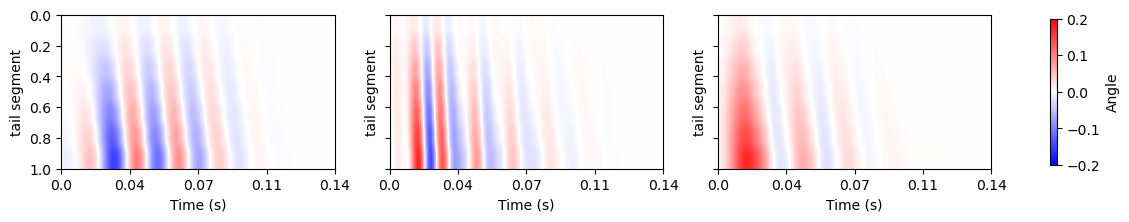

In [3]:

Dict = np.load('../megabouts/sparse_coding/3atomsDictTu.npy')

D = Dict

fig, (ax) = plt.subplots(1,3,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

# Load Data


In [4]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')
#df = df.iloc[:700*90,:]


x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)
tail_angle[tail_angle<-10]=np.nan # Set Nan when tail angle out of range:


# Run Pipeline:

In [5]:

cfg_tail_preprocess = ConfigTailPreprocess(fps=700,num_pcs=4,limit_na_ms=100,
                                           baseline_method='slow',
                                           baseline_params={'fps':700})

cfg_traj_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)

cfg_sparse_coding = ConfigSparseCoding(fps=700,Dict=Dict,lmbda=0.01,gamma=0.3,mu=0.3,window_inhib_ms=85)

cfg_segment = ConfigTailSegmentation(fps=700,
                                     peak_prominence=0.4,min_code_height=1,min_spike_dist_ms=200,
                                     margin_before_peak_ms=40,bout_duration_ms=200)

cfg_classify = ConfigClassification(fps=700,
                                      margin_before_peak_ms=40,
                                      bout_duration_ms=200,
                                      augment_min_delay_ms=-2,
                                      augment_max_delay_ms=2,
                                      augment_step_delay_ms=2,
                                      feature_weight= np.array([1.6]*7+[0.5,0.4,1]),
                                      N_kNN=10
                                      )

pipeline = PipelineFullTracking(cfg_tail_preprocess,
                                cfg_traj_preprocess,
                                cfg_sparse_coding,
                                cfg_segment,
                                cfg_classify,

                                load_training=True)

(46710, 10, 170)
TimeStep:140,OriginalPeakLoc:30,TargetPeak:28
augmentation_delays:[-1  0  1]
IdSt:3
IdSt:2
IdSt:1


In [8]:
res = pipeline.run(tail_angle,x,y,body_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  1.79e+05  2.85e+04  3.71e+05  2.94e+05  1.95e+05  4.34e-01  1.59e+01  1.50e+00
   1  3.98e+05  2.11e+04  4.34e+05  7.31e+05  5.10e+05  9.57e-01  1.90e+00  1.50e+00
   2  5.57e+05  4.31e+04  4.62e+05  1.07e+06  6.25e+05  9.62e-01  7.62e-02  1.04e+00
   3  4.52e+05  7.26e+04  2.66e+05  7.63e+05  4.92e+05  6.42e-01  3.51e-01  3.58e+00
   4  4.27e+05  1.00e+05  1.98e+05  6.13e+05  4.68e+05  2.55e-01  2.85e-01  4.72e+00
   5  4.11e+05  9.54e+04  1.89e+05  5.43e+05  5.02e+05  1.78e-01  1.85e-01  4.72e+00
   6  3.94e+05  9.86e+04  1.71e+05  4.83e+05  4.97e+05  1.42e-01  1.24e-01  4.72e+00
   7  3.81e+05  1.04e+05  1.57e+05  4.27e+05  4.90e+05  1.09e-01  9.90e-02  4.72e+00
   8  3.78e+05  1.07e+05  1.52e+05  4.04e+05  4.93e+05  8.43e-02  7.20e-02  4.72e+00
   9  3.68e+05  1.07e+05  1.48e+05  3.69e+05  4.96e+05  6.64e-02 

In [10]:
tail_angle_hat = res.sparse_code.tail_angle_hat
z = res.sparse_code.z
decomposition = res.sparse_code.decomposition

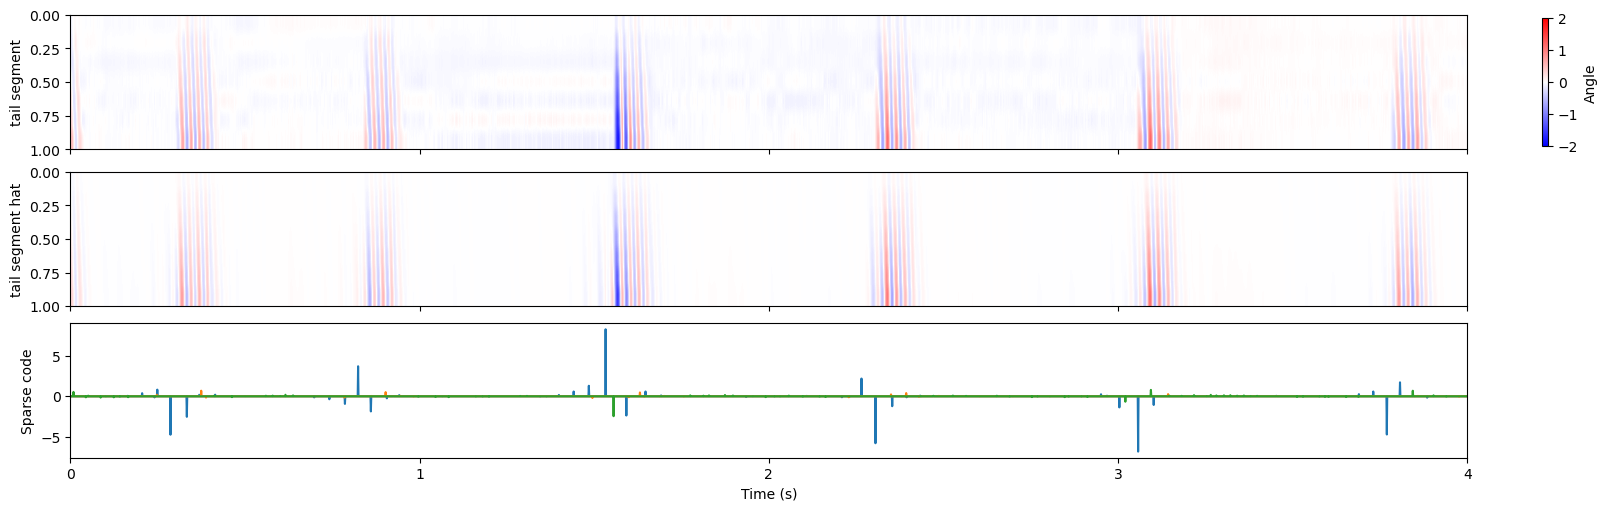

In [11]:
Duration = 700*5
IdSt= np.random.randint(z.shape[0]-Duration)

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)
im = ax[0].imshow(tail_angle[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[0].set_ylabel('tail segment')
im = ax[1].imshow(tail_angle_hat[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[1].set_ylabel('tail segment hat')
ax[2].plot(z[IdSt:IdSt+Duration,:])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sparse code')
ax[2].set_xticks(np.linspace(0,Duration,5))

ax[2].set_xticklabels(np.arange(0,5))

cbar = fig.colorbar(im, ax=ax[0], shrink=0.95)
cbar.set_label('Angle')
plt.show()

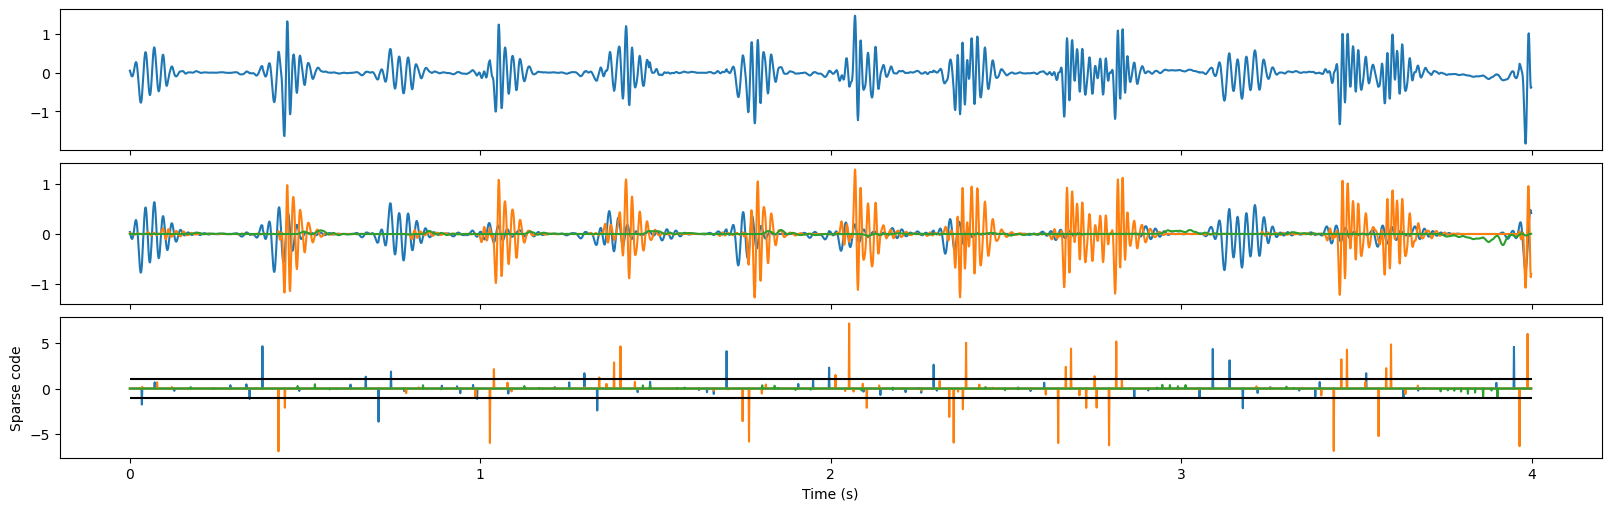

In [12]:
Duration = 700*5
IdSt= np.random.randint(z.shape[0]-Duration)

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)
ax[0].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])
ax[1].plot(decomposition[IdSt:IdSt+Duration,:])
ax[2].plot(z[IdSt:IdSt+Duration,:])
ax[2].hlines(cfg_segment.min_code_height,0,Duration,color='k')
ax[2].hlines(-cfg_segment.min_code_height,0,Duration,color='k')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sparse code')
ax[2].set_xticks(np.linspace(0,Duration,5))
ax[2].set_xticklabels(np.arange(0,5))
plt.show()

In [13]:

templates_labels = pipeline.knn_training_dataset_augmented.labels
tail_and_traj_array = res.tail_and_traj_array
bout_category = res.classification.bout_category
proba = res.classification.proba
outlier = res.classification.outlier_score
NameCat = cfg_classify.bouts_dict['name']

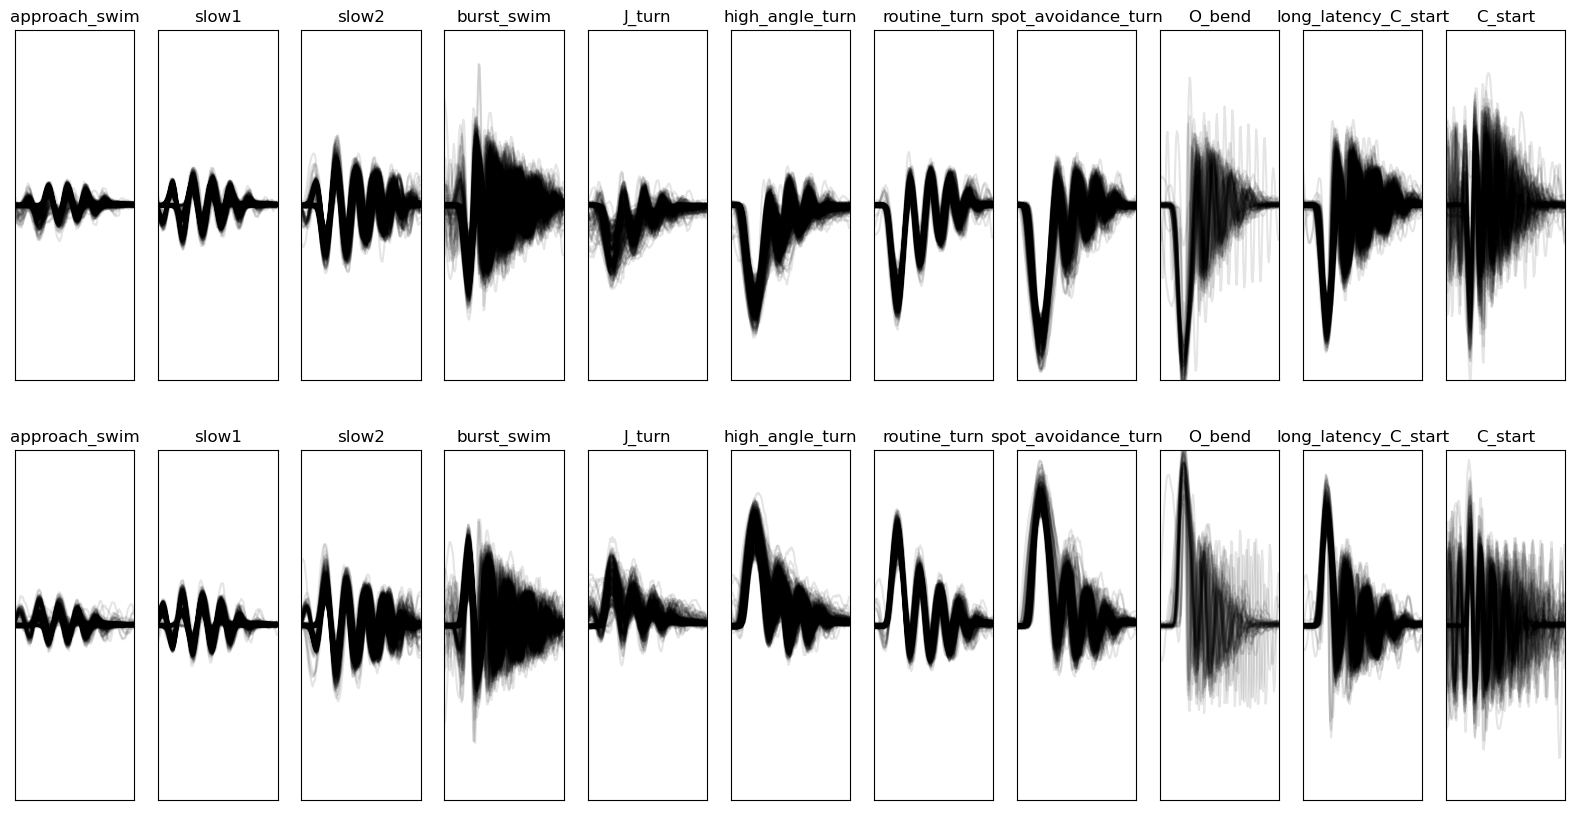

In [18]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,11)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<11 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%11])
    ax0.set_title(NameCat[b%11])
    id = np.where((bout_category==b)&(proba>0.7)&(outlier<2))[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(tail_and_traj_array[id,6,:].T,'k',alpha=0.1)

    ax0.set_xlim(0,cfg_segment.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()

# Display example results

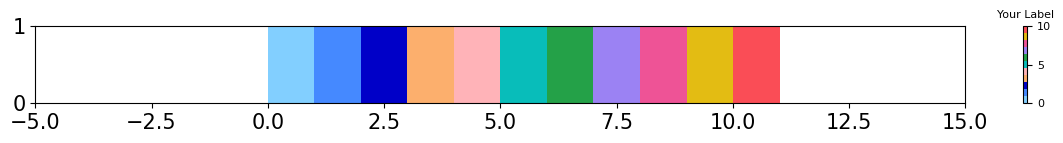

In [24]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

color = cfg_classify.bouts_dict['color']

cmp_bouts = colors.ListedColormap(color)
cmp_bouts.set_under(color='white')
cmp_bouts.set_over(color='white')
cmp_bouts.set_bad(color='grey', alpha=None)

plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,15)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=10,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [25]:
segments = res.segments
id_nearest_template = res.classification.id_nearest_template_aligned

In [26]:
fps = cfg_tail_preprocess.fps
Duration = fps*7
IdSt = np.random.randint(tail_angle.shape[0]-Duration)
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)

sub_onset,sub_offset,sub_i= [],[],[]
for i,(on_,off_) in enumerate(zip(segments.onset,segments.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)
sub_i = np.array(sub_i)
sub_onset = np.array(sub_onset)
sub_offset = np.array(sub_offset)

sub_tail_array = tail_and_traj_array[sub_i,:7,:]
id = id_nearest_template[sub_i]
tail_nearest = pipeline.knn_training_dataset_augmented.tail[id,:,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

(-3.6, 3.6)

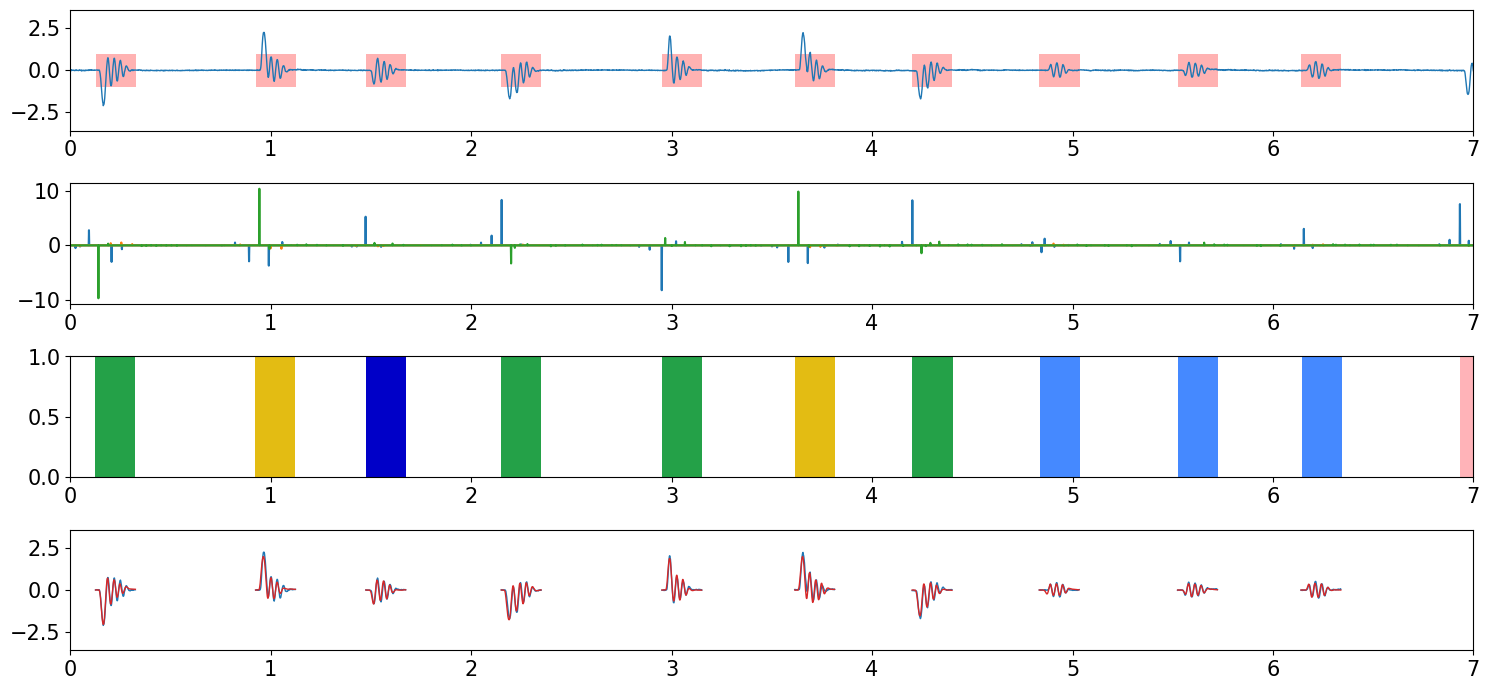

In [27]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(4,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)
ax = plt.subplot(G[1])
ax.plot(t,z[IdSt:IdEd,:])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[2])
ax.imshow(res.bout_category_ts[IdSt:IdEd,np.newaxis].T,
          cmap=cmp_bouts,
          aspect='auto',
          vmin=0,vmax=10,
          interpolation='nearest',extent=[0,Duration/fps,0,1])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[3])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    #ax.plot((np.arange(on_,off_))/fps,tail_angle_detrend[on_+IdSt:off_+IdSt,-1],'tab:blue')
    ax.plot((np.arange(on_,off_))/fps,sub_tail_array[i,-1,:],'tab:blue',lw=1)
    #off_ = on_+140
    ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)


(0.0, 7.0)

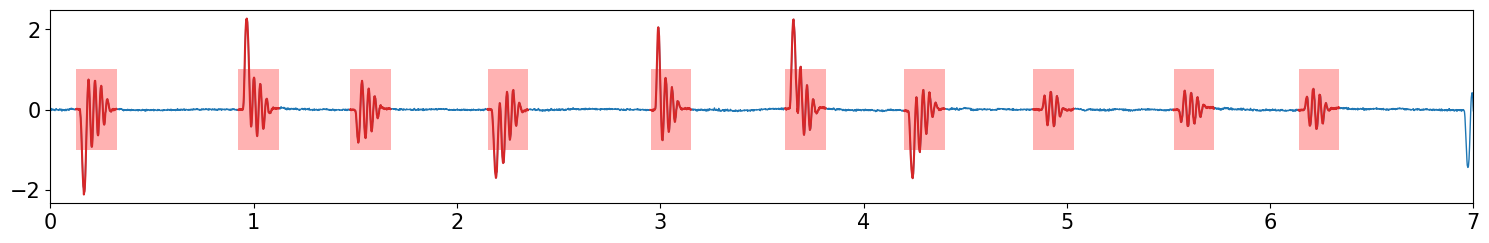

In [28]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(3,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[0])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_))/fps,res.tracking_data_clean.tail_angle[on_+IdSt:off_+IdSt,6],'tab:red')
    off_ = on_+140
#ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)

# Illustration of sparse coding

[0 1 2]


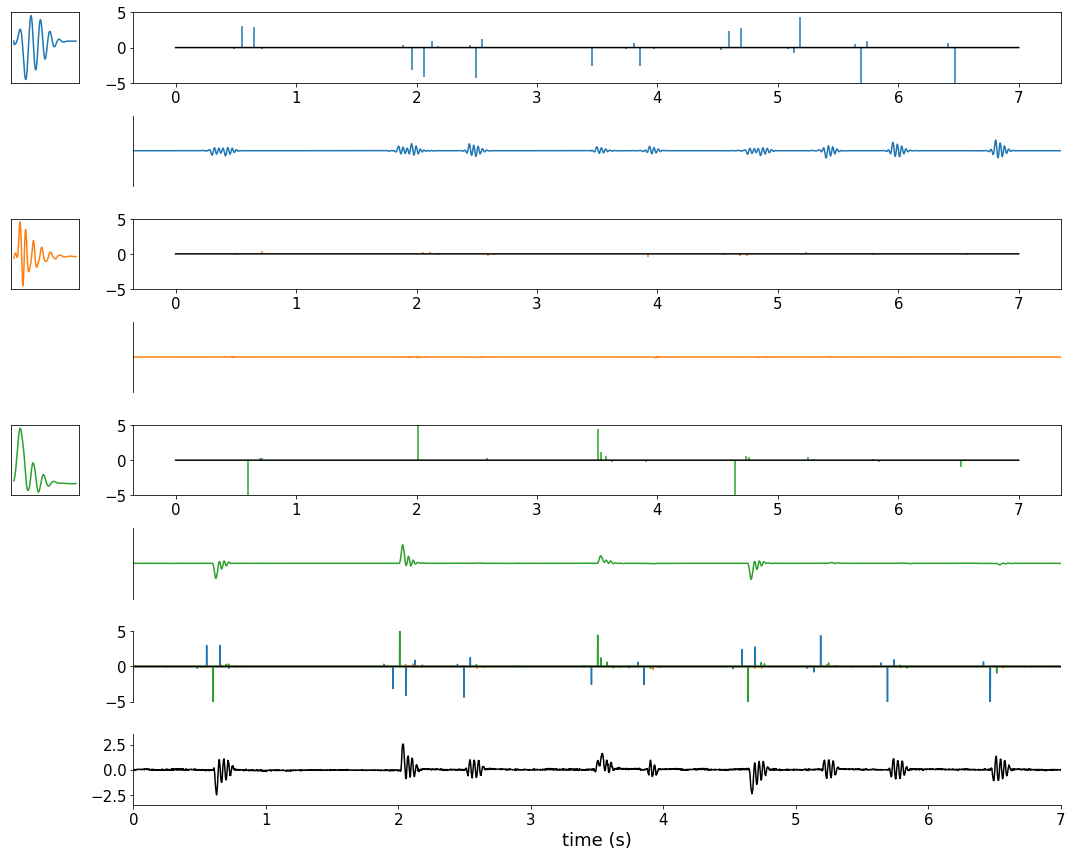

In [45]:
code = np.copy(z)
t = np.arange(0,Duration)/700
id_atom = np.where(np.sum(np.abs(code[IdSt:IdEd,:]),axis=0)>5)[0]

#id_atom = [i for i in ordered_atom if np.any(np.isin(id_atom,i))]
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(facecolor='white',figsize=(15,12),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(2*N+2,9)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle[IdSt:IdEd,7],'k')
ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,code[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_ylim(-5,5)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
k=0
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[k,1:])
    ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
    y = code[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]

    if len(x)>0:
        markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
        baseline.remove()
        markerline[i].remove()
        #plt.setp(markerline[i], color=cmaplist[i]) 
        plt.setp(stemline[i], color=cmaplist[i])
    ax.set_ylim(-5,5)

    
    ax = plt.subplot(G[k+1,1:])
    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
        
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[k:k+1,0])
    ax.plot(Dict[:,-1,i_code],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])

    k=k+2


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()